# Time Series Prediction with Knowledge Based Deep Learning ($KDL$)



AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-13 18:16:20

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Loading Datasets

_KYOTO DST_

In [3]:
data = pd.read_csv("datasets/dst.csv")
training_set = data.iloc[:, 1]
print(training_set)

0         -7
1        -10
2        -10
3         -6
4         -2
          ..
139867   -16
139868   -14
139869   -14
139870   -15
139871   -14
Name: dst, Length: 139872, dtype: int64


In [4]:
t_diff = 0.0416 # Hourly Data (1/24)
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

67
1         -72.115385
2           0.000000
3          96.153846
4          96.153846
5         120.192308
             ...    
139867     96.153846
139868     48.076923
139869      0.000000
139870    -24.038462
139871     24.038462
Name: dst, Length: 139871, dtype: float64
2         1733.542899
3         2311.390533
4            0.000000
5          577.847633
6        -1733.542899
             ...     
139867       0.000000
139868   -1155.695266
139869   -1155.695266
139870    -577.847633
139871    1155.695266
Name: dst, Length: 139870, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         -72.115385
1           0.000000
2          96.153846
3          96.153846
4         120.192308
             ...    
139866     96.153846
139867     48.076923
139868      0.000000
139869    -24.038462
139870     24.038462
Name: dst, Length: 139871, dtype: float64
0         1733.542899
1         2311.390533
2            0.000000
3          577.847633
4        -1733.542899
             ...     
139865       0.000000
139866   -1155.695266
139867   -1155.695266
139868    -577.847633
139869    1155.695266
Name: dst, Length: 139870, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the data into supervised learning

In [7]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)  # ,18,19
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        -7.0      -10.0      -10.0       -6.0       -2.0        3.0   
11       -10.0      -10.0       -6.0       -2.0        3.0        5.0   
12       -10.0       -6.0       -2.0        3.0        5.0        5.0   
13        -6.0       -2.0        3.0        5.0        5.0        3.0   
14        -2.0        3.0        5.0        5.0        3.0        1.0   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)    var2(t)     var3(t)  
10        5.0        5.0        3.0        1.0      1.0  24.038462 -577.847633  
11        5.0        3.0        1.0        1.0      2.0   0.000000  577.847633  
12        3.0        1.0        1.0        2.0      2.0  24.038462 -577.847633  
13        1.0        1.0        2.0        2.0      3.0   0.000000  577.847633  
14        1.0        2.0        2.0        3.0      3.0  24.038462  577.847633  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
  

## Train and Test Split

In [8]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(111888, 1, 10) (111888, 3) (27972, 1, 10) (27972, 3)


## Model ($KDL$)

In [9]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
1749/1749 [==============================] - 16s 8ms/step - loss: 0.0042 - val_loss: 2.0984e-04
Epoch 2/500
1749/1749 [==============================] - 7s 4ms/step - loss: 4.9301e-04 - val_loss: 1.3668e-04
Epoch 3/500
1749/1749 [==============================] - 5s 3ms/step - loss: 3.2940e-04 - val_loss: 1.3097e-04
Epoch 4/500
1749/1749 [==============================] - 5s 3ms/step - loss: 3.0535e-04 - val_loss: 1.3119e-04
Epoch 5/500
1749/1749 [==============================] - 6s 3ms/step - loss: 2.9740e-04 - val_loss: 1.2827e-04
Epoch 6/500
1749/1749 [==============================] - 5s 3ms/step - loss: 2.9402e-04 - val_loss: 1.2898e-04
Epoch 7/500
1749/1749 [==============================] - 5s 3ms/step - loss: 2.9143e-04 - val_loss: 1.2760e-04
Epoch 8/500
1749/1749 [==============================] - 4s 3ms/step - loss: 2.8883e-04 - val_loss: 1.2692e-04
Epoch 9/500
1749/1749 [==============================] - 5s 3ms/step - loss: 2.8681e-04 - val_loss: 1.2642e-04
Epoc

## Metrics ($KDL$)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

875/875 [==============================] - 5s 3ms/step
(27972, 3)
(27972, 10)
Test RMSE: 2.742
Test MAE: 1.933


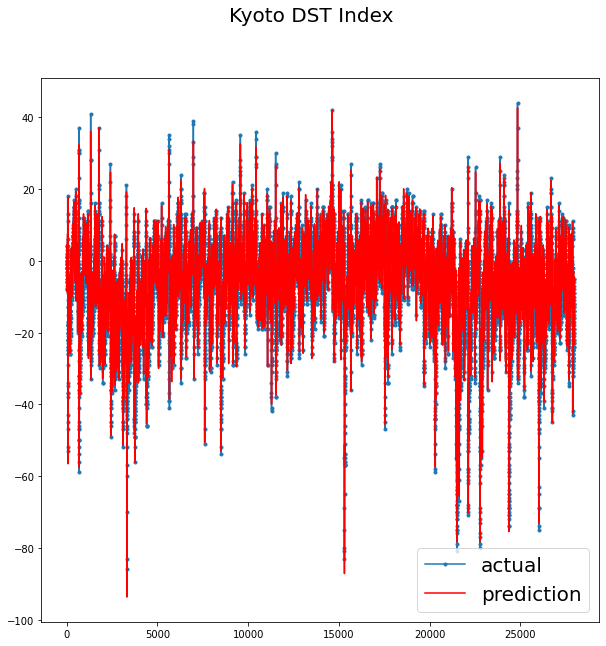

In [11]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('Kyoto DST Index', fontsize=20)
plt.legend(fontsize=20)
plt.show()